# HPC Mini-Challenge 2 - Beschleunigung in Data Science
## Teil 2: GPU
#### FHNW - FS22

Original von S. Suter, angepasst für das HS22 von S. Marcin

Abgabe von: <font color='blue'>Name hier eintragen</font>

#### Ressourcen
* [Überblick GPU Programmierung](https://www.cherryservers.com/blog/introduction-to-gpu-programming-with-cuda-and-python)
* [CUDA Basic Parts](https://nyu-cds.github.io/python-gpu/02-cuda/)
* [Accelerate Code with CuPy](https://towardsdatascience.com/heres-how-to-use-cupy-to-make-numpy-700x-faster-4b920dda1f56)
* Vorlesungen und Beispiele aus dem Informatikkurs PAC (parallel computing), siehe resourcen
* CSCS "High-Performance Computing with Python" Kurs, Tag 3: 
    - JIT Numba GPU 1 + 2
    - https://youtu.be/E4REVbCVxNQ
    - https://github.com/eth-cscs/PythonHPC/tree/master/numba-cuda
    - Siehe auch aktuelles Tutorial von 2021
* [Google CoLab](https://colab.research.google.com/) oder ggf. eigene GPU.


In [1]:
#!pip install numba

In [2]:
!nvidia-smi
!nvcc --version

Mon Jan 16 10:54:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   49C    P8    10W /  N/A |    377MiB /  8192MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Dummy Beispiel zum testen mit Numba
import os
import numpy as np
import time
import math
import imageio
import numpy as np
from numba import vectorize, cuda, float32
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image

@vectorize(['float32(float32)'], target='cuda')
def gpu_sqrt(x):
    return math.sqrt(x)
  

a = np.arange(4096,dtype=np.float32)
gpu_sqrt(a)

C:\Users\samlu\AppData\Roaming\Python\Python39\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (4) < 2 * SM count (72) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([ 0.       ,  1.       ,  1.4142135, ..., 63.97656  , 63.98437  ,
       63.992188 ], dtype=float32)

In [4]:
def reconstruct_svd(u,s,vt,k):
    """SVD reconstruction for k components using np.dot()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    reco = np.dot(u[...,:k], np.dot(np.diag(s[:k]), vt[:k,...]))
        
    return reco

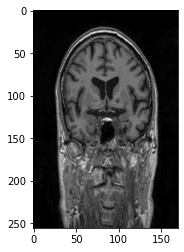

In [5]:
from PIL import Image
im = Image.open('adni_png/001/m1-1_slice125.png').convert('L')
# im = Image.open('Sunflower.jpg').convert('L')
im = im - np.min(im) / np.max(im) - np.min(im) # normalize data 
plt.imshow(im, cmap="gray")
plt.show()

In [6]:
u,s,vt = np.linalg.svd(im, full_matrices=False)

u = u.astype("float32")
s = s.astype("float32")
vt = vt.astype("float32")

u.shape, s.shape, vt.shape, u.dtype

((256, 170), (170,), (170, 170), dtype('float32'))

### 5 GPU Rekonstruktion

Implementiere eine SVD-Rekonstruktionsvariante auf der GPU oder in einem hybriden Setting. Code aus dem ersten Teil darf dabei verwendet werden. Wähle  bewusst, welche Teile des Algorithms in einem GPU Kernel implementiert werden und welche effizienter auf der CPU sind. Ziehe dafür Erkenntnisse aus dem ersten Teil mit ein. Es muss mindestens eine Komponente des Algorithmuses in einem GPU-Kernel implementiert werden. Dokumentiere Annahmen, welche du ggf. zur Vereinfachung triffst. Evaluiere, ob du mit CuPy oder Numba arbeiten möchtest. Diskutiere deine Entscheidungen in 150-200 Wörtern. 

Links:
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)

<font color='blue'>Um die kosten fürs laden der Arrays vom Host zum Device möglichst gering zu halten werden die Singulärwerte jeweils schon auf der CPU verworfen.</font>

<font color='blue'>**Variante 1: Ohne Shared Memory**</font>

<font color='blue'>Bei der ersten Variante wird die gesammte Rekonstruktion auf der GPU ohne die Verwendung des Shared Memory vom Threadblock. Dabei ist pro Pixel jeweils ein Thread aktiv für die Rekonstruktion.</font>

C:\Users\samlu\AppData\Roaming\Python\Python39\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (48) < 2 * SM count (72) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


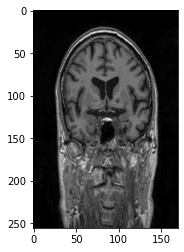

Max pixelwise diff: 3.0517578e-05


In [7]:
@cuda.jit
def reconstruct_svd_cuda_1(u, s, vt, reco):
    
    j, i = cuda.grid(2)
    if i < reco.shape[0] and j < reco.shape[1]:
        tmp = 0.
        for n in range(s.shape[0]):
            tmp += u[i, n] * s[n] *  vt[n, j]
        reco[i, j] = tmp

        
def reconstruct_svd_numba_setup(u, s, vt, k, reconstruction_method, TPB=32, verbose=False):

    reco = np.zeros((u.shape[0], vt.shape[1])).astype("float32")
    
    # to_device funktioniert nur wenn nochmals np.array ums slicing herum. why???
    u = np.array(u[:, 0:k])
    s = np.array(s[0:k])
    vt = np.array(vt[0:k, :])
    
    #copy to GPU
    u_gpu = cuda.to_device(u)
    s_gpu = cuda.to_device(s)
    vt_gpu = cuda.to_device(vt)
    reco_gpu = cuda.to_device(reco)

    threadsperblock = (TPB, TPB)
    grid_y_max = max(u.shape[0], vt.shape[0])
    grid_x_max = max(u.shape[1], vt.shape[1])
    blockspergrid_x = math.ceil(grid_x_max / threadsperblock[0])
    blockspergrid_y = math.ceil(grid_y_max / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    
    if verbose:
        print(f"Blocks Per Grid: {blockspergrid}\nThreads Per Block: {threadsperblock}\n")

    reconstruction_method[blockspergrid, threadsperblock](u_gpu, s_gpu, vt_gpu, reco_gpu)

    # copy to CPU
    reco = reco_gpu.copy_to_host()
    return reco


def reconstruct_svd_numba_cuda(m_numba, m_cuda, TPB):
    return lambda u, s, vt, k: m_numba(u, s, vt, k, m_cuda, TPB)



TPB=32
k=min(im.shape)
reco_svd_cuda_1 = reconstruct_svd_numba_cuda(reconstruct_svd_numba_setup, reconstruct_svd_cuda_1, TPB)
reco = reco_svd_cuda_1(u, s, vt, k)
plt.imshow(reco, cmap="gray")
plt.show()
print("Max pixelwise diff:", np.max(reco - im))

<font color='blue'>Antwort hier eingeben</font>

#### 5.2 GPU-Kernel Performance

##### 5.2.1 Blocks und Strided Access

Links: 
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)
* [NVIDIA Kapitel zu "Strided Access"](https://spaces.technik.fhnw.ch/multimediathek/file/cuda-best-practices-in-c)
* https://developer.nvidia.com/blog/cublas-strided-batched-matrix-multiply/
* https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/

Führe 2-3 Experimente mit unterschiedlichen Blockkonfigurationen und Strided Access durch, auf welchen dein GPU-Kernel arbeitet. Messe die Performance des GPU-Kernels mittels geeigneten Funktionen. Welche Blockgrösse und welcher Strided Access hat sich bei dir basierend auf deinen Experimenten als am erfolgreichsten erwiesen? Welches sind deiner Meinung nach die Gründe dafür? Wie sind die Performance Unterschiede zwischen deiner CPU und GPU Implementierung? Diskutiere deine Analyse in ca. 200 Wörtern und ggf. mit Grafiken. 

<font color='blue'>**Variante 2: Mit Shared Memory**</font>

<font color='blue'>Bei der zweiten Variante wird nun die Rekonstruktion auf der GPU inklusive Verwendung des Shared Memory vom Threadblock umgesetzt. 

C:\Users\samlu\AppData\Roaming\Python\Python39\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (48) < 2 * SM count (72) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Max pixelwise diff: 0.00018310547


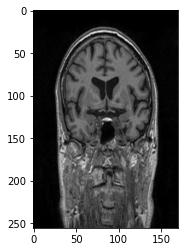

In [8]:
### BEGIN SOLUTION
import numpy as np
from numba import cuda, float32

@cuda.jit
def reconstruct_svd_cuda_2(u, s, vt, reco):
    """
    Perform matrix multiplication of reco = u * s * vt using CUDA shared memory.

    Reference: https://stackoverflow.com/a/64198479/13697228 by @RobertCrovella
    """
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    u_shared = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    s_shared = cuda.shared.array(shape=(TPB), dtype=float32)
    vt_shared = cuda.shared.array(shape=(TPB, TPB), dtype=float32)


    x, y = cuda.grid(2) # 2 dim
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.y    # blocks per grid
   
    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = float32(0.)
    for i in range(bpg):
        # Preload data into shared memory
        u_shared[ty, tx] = 0
        if tx < 1:
            s_shared[tx] = 0
        vt_shared[ty, tx] = 0
        
        if y < u.shape[0] and (tx + i * TPB) < u.shape[1]:
            u_shared[ty, tx] = u[y, tx + i * TPB]
            
        if (tx + i * TPB) < s.shape[0]:
            s_shared[tx] = s[tx + i * TPB]
        
        if x < vt.shape[1] and (ty + i * TPB) < vt.shape[0]:
            vt_shared[ty, tx] = vt[ty + i * TPB, x]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += u_shared[ty, j] * s_shared[j] * vt_shared[j, tx]

        # Wait until all threads finish computing
        cuda.syncthreads()
        
    if y < reco.shape[0] and x < reco.shape[1]:
        reco[y, x] = tmp
    

TPB=32
k=min(im.shape)
reco_svd_cuda_2 = reconstruct_svd_numba_cuda(reconstruct_svd_numba_setup, reconstruct_svd_cuda_2, TPB)
reco = reco_svd_cuda_2(u, s, vt, k)
plt.imshow(reco, cmap="gray")
print("Max pixelwise diff:", np.max(reco - im))
### END SOLUTION

<font color='blue'>**Vergleich der Laufzeiten mit uinterschiedlichen TPB**</font>

<font color='blue'>Nachfolgend werden die Laufzeiten für die Rekonstruktion des im Verhältnis zur Anzahl an Threads pro Block für ein einzelnen MRI Bild verglichen.</font>

In [9]:
Threads_Per_Block = [4, 8, 16, 32]
k=min(im.shape)

n_iter = 10
TPB_times = pd.DataFrame(columns = ("TPB", "time"))
for TPB in Threads_Per_Block:
    print(TPB)
    
    reco_svd_cuda_2 = reconstruct_svd_numba_cuda(reconstruct_svd_numba_setup, reconstruct_svd_cuda_2, TPB)
    print(reco_svd_cuda_2)
    
    for i in range(n_iter):
        start = time.time()
        reco = reco_svd_cuda_2(u, s, vt, k)
        stop = time.time()
    
        TPB_times = TPB_times.append({"TPB":TPB, "time":(stop-start)/n_iter}, ignore_index=True)

4
<function reconstruct_svd_numba_cuda.<locals>.<lambda> at 0x000001E99B177AF0>
8
<function reconstruct_svd_numba_cuda.<locals>.<lambda> at 0x000001E99B177B80>
16
<function reconstruct_svd_numba_cuda.<locals>.<lambda> at 0x000001E99B177AF0>
32
<function reconstruct_svd_numba_cuda.<locals>.<lambda> at 0x000001E99B177B80>


C:\Users\samlu\AppData\Roaming\Python\Python39\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (48) < 2 * SM count (72) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


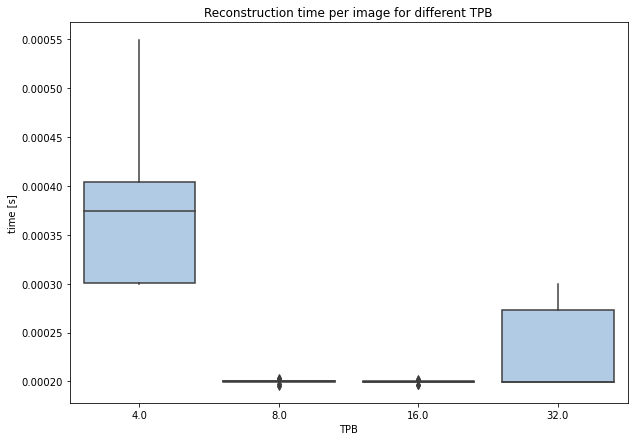

In [10]:
plt.figure(figsize=(10,7))
sns.boxplot(data=TPB_times, x="TPB", y="time", showcaps=False, boxprops={"facecolor": (.4, .6, .8, .5)})
plt.title("Reconstruction time per image for different TPB")
plt.ylabel("time [s]")
plt.show()

<font color='blue'>Welche TPB-Grösse am effizientesten ist, kann von verschiedenen Faktoren Abhänig sein wie die grösse der zu verrechnenden Matrize, die grösse des Shared Memory oder der maximalen Anzahl an unterstützten Threads pro Block. Dabei geht es Primär darum den Warp optimal auszulasten, weshalb die Anzahl TPB ein Teiler der Warp-Grösse sein sollte, welche auf den aktuellen Geräten 32 beträgt.</font>

<font color='blue'>Die Visualisierung zeigt die Laufzeit für das Rekonstruieren eines einzelnen Bildes aus dem MRI Datensatz (170x256 Pixel). Mit kleinen Matrizen scheint die Laufzeit mit 16 Threads pro Block am kürzesten zu sein. Eigentlich hätte ich erwartet, dass eine höhere Anzahl an Threads in den Blocken eine Bessere effizienz erreichen. Das ist hier scheinbar nicht der Fall.</font>

<font color='blue'>Nachfolgend werden die Laufzeiten für die Rekonstruktion des im Verhältnis zur Anzahl an Threads pro Block für ein Bild mit einer Grösse von 3000x3000 Pixel verglichen.</font>

In [11]:
im2 = np.random.normal(0, 1, (3000,3000))
u2,s2,vt2 = np.linalg.svd(im2, full_matrices=False)
u2 = u2.astype("float32")
s2 = s2.astype("float32")
vt2 = vt2.astype("float32")

Threads_Per_Block = [32, 16, 8, 4]
k=min(im2.shape)

n_iter = 10
TPB_times = pd.DataFrame(columns = ("TPB", "time"))
for TPB in Threads_Per_Block:
    print(TPB)
    
    reco_svd_cuda_2 = reconstruct_svd_numba_cuda(reconstruct_svd_numba_setup, reconstruct_svd_cuda_2, TPB)
    
    for i in range(n_iter):
        start = time.time()
        reco = reco_svd_cuda_2(u2, s2, vt2, k)
        stop = time.time()
    
        TPB_times = TPB_times.append({"TPB":TPB, "time":(stop-start)/n_iter}, ignore_index=True)

32
16
8
4


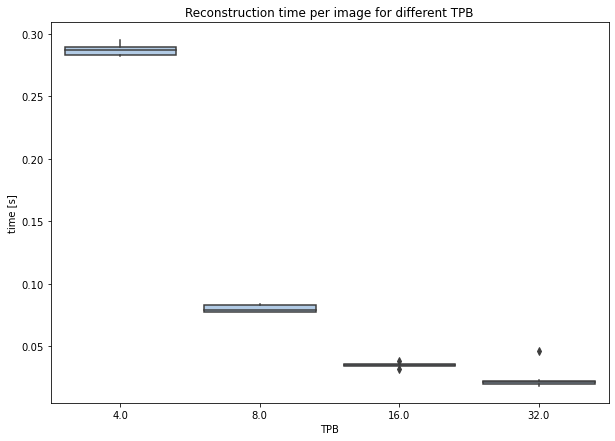

In [12]:
plt.figure(figsize=(10,7))
sns.boxplot(data=TPB_times, x="TPB", y="time", showcaps=False, boxprops={"facecolor": (.4, .6, .8, .5)})
plt.title("Reconstruction time per image for different TPB")
plt.ylabel("time [s]")
plt.show()

<font color='blue'>Die Visualisierung zeigt für unser grösseres Bild einen starken negativen Zusammenhang zwischen der Anzahl an Threads pro Block und der Rekonstruktionszeit eines Bildes. Das entspricht nun eher meinem erwarteten Verhalten, da wenn weniger Threads innerhalb des Blockes parallel laufen, resp. weniger Pixel parallel rekonstruiert werden, auch mehr Blöcke über die SM nacheinander ausgeführt werden, was die Laufzeit erhöht. </font>

##### 5.2.2 Memoryallokation auf der GPU
Führe 2-3 Experimente durch in welchem du unterschiedliche Varianten des Transfers der Daten bzw. der Memory-Allokation auf die GPU miteinander vergleichst. Messe die Varianten mittels geeigneten Methoden. Als Beispiel können hier z.B. unterschiedlich grosse Packages an Daten auf die GPU kopiert und dann verarbeitet werden oder die Daten werden in unterschiedliche Memory-Typen geladen.

Links:
* [Best Practices Memory Optimizations](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations)
* [Examples: Matrix Multiplikation und Shared Memory](https://numba.readthedocs.io/en/latest/cuda/examples.html)

In [13]:
### BEGIN SOLUTION
### END SOLUTION

Was sind deine Erkenntnisse bzgl. GPU-Memory-Allokation und des Daten-Transferes auf due GPU? Wie hast du ggf. deine Implementierung aus 5.1 angepasst? Diskutiere deine Antwort in ca. 150-200 Wörtern.

<font color='blue'>Antwort hier eingeben</font>

##### 5.2.3 Bonus: Memoryoptimierung
Optimiere die Memory-Allokation in deiner Implementierung, so dass du einen Leistungssteigerung zu einer anderen Variante demonstrieren kannst.

<font color='blue'>**Variante 3: Mit Shared Memory & Pre-Loading**</font>

Max pixelwise diff: 0.00018310547


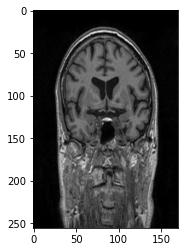

In [14]:
### BEGIN SOLUTION
import math

@cuda.jit
def reconstruct_svd_cuda_3(u, s, vt, reco):
    """
    Perform matrix multiplication of reco = u * s * vt using CUDA shared memory.
    """
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    u_shared1 = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    s_shared1 = cuda.shared.array(shape=(TPB), dtype=float32)
    vt_shared1 = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    
    u_shared2 = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    s_shared2 = cuda.shared.array(shape=(TPB), dtype=float32)
    vt_shared2 = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2) # 2 dim
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.y    # blocks per grid
    
    u_shared1[ty, tx] = 0
    if tx < 1:
        s_shared1[tx] = 0
    vt_shared1[ty, tx] = 0
    
    if y < u.shape[0] and tx < u.shape[1]:
        u_shared1[ty, tx] = u[y, tx]

    if tx < s.shape[0]:
        s_shared1[tx] = s[tx]

    if x < vt.shape[1] and ty < vt.shape[0]:
        vt_shared1[ty, tx] = vt[ty, x]
        
    cuda.syncthreads()
   
    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = float32(0.)
    for i in range(1, bpg + 1):
        
        # update shared memory
        u_shared1, u_shared2 = u_shared2, u_shared1
        s_shared1, s_shared2 = s_shared2, s_shared1
        vt_shared1, vt_shared2 = vt_shared2, vt_shared1
        
        u_shared1[ty, tx] = 0
        if tx < 1:
            s_shared1[tx] = 0
        vt_shared1[ty, tx] = 0

        if y < u.shape[0] and (tx + i * TPB) < u.shape[1]:
            u_shared1[ty, tx] = u[y, tx + i * TPB]
            
        if (tx + i * TPB) < s.shape[0]:
            s_shared1[tx] = s[tx + i * TPB]
        
        if x < vt.shape[1] and (ty + i * TPB) < vt.shape[0]:
            vt_shared1[ty, tx] = vt[ty + i * TPB, x]     

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += u_shared2[ty, j] * s_shared2[j] * vt_shared2[j, tx]

        # Wait until all threads finish computing
        cuda.syncthreads()
        
        
    if y < reco.shape[0] and x < reco.shape[1]:
        reco[y, x] = tmp
    

TPB=16
k=min(im.shape)
reco_svd_cuda_3 = reconstruct_svd_numba_cuda(reconstruct_svd_numba_setup, reconstruct_svd_cuda_3, TPB)
reco = reco_svd_cuda_3(u, s, vt, k)
plt.imshow(reco, cmap="gray")
print("Max pixelwise diff:", np.max(reco - im))
### END SOLUTION

#### 5.3 NVIDIA Profiler

Benutze einen Performance Profiler von NVIDIA, um Bottlenecks in deinem Code zu identifizieren bzw. unterschiedliche Implementierungen (Blocks, Memory etc.) zu vergleichen. 

* Siehe Beispiel example_profiling_CUDA.ipynb
* [Nsight](https://developer.nvidia.com/nsight-visual-studio-edition) für das Profiling des Codes und die Inspektion der Ergebnisse (neuste Variante)
* [nvprof](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview)
* [Nvidia Visual Profiler](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#visual)

> Du kannst NVIDIA Nsights Systems und den Nvidia Visual Profiler auf deinem PC installieren und die Leistungsergebnisse aus einer Remote-Instanz visualisieren, auch wenn du keine GPU an/in deinem PC hast. Dafür kannst du die ``*.qdrep`` Datei generieren und danach lokal laden.


Dokumentiere deine Analyse ggf. mit 1-2 Visualisierungen und beschreibe in 3-5 Sätzen, welche Bottlenecks du gefunden bzw. entschärft hast.

<font color='blue'>Nachfolgend werden die mit nvidia nsight compute generierten Reports für die Varianten v1, v2 und v3 gezeigt. Für die Rekonstruktion wurde jeweils eine 3000x3000 Pixel grosse Matrize zerlegt. </font>

In [15]:
# !nvcc -h

In [16]:
# !ncu -f -o v1 --set full --target-processes all python C:/Users/samlu/Documents/GitHub/hs22-mc2/v1.py

<font color='blue'>**Variante 1: Ohne Shared Memory**</font>

<img src="images/ncu_v1.png" alt="nvidia nsight compute v1"/> 

<font color='blue'>**Beschreibung:** Diese Variante nutzt wie zuvor schon erwähnt kein Shared Memory für die Rekonstruktion. Das ist im Report entsprechend in der *Memory Chart* erkennbar.

<font color='blue'>Beim Betrachten der Auslastung der Komponenten auf der GPU unter dem Abschnitt *GPU Utilization* sieht man, dass der Streaming-Multiprozessor mit > 85 Prozent fast komplett ausgelastet ist, während das Laden der Daten aus dem Memory mit ca. 17 Prozent Auslastung noch Luft nach oben hätte.  </font>
    
<font color='blue'>Bei der *Floating Point Operation Roofline* wird die Warnung generiert, dass der Kernel 1 % der fp32-Spitzenleistung und 21 % der fp64-Spitzenleistung auf der GPU erreicht hat, was auf ein Bottlenech in dieser Komponente hindeutet. </font>
    
<font color='blue'>In der *Memory Workload analysis* ist zu sehen, dass die FP64 Pipeline am stärksten ausgelastet ist und ein Bottleneck in der Rekonstruktion ist. Das passt zu den vorgehenden Beobachtungen. Die FP64 Pipeline selbst führt arithmetische Operationen für Float64 Einheiten durch und kann eingesetzt werden für Berechnungen, welche genau sein müssen. </font>

In [17]:
# !ncu -f -o v2 --set full --target-processes all python C:/Users/samlu/Documents/GitHub/hs22-mc2/v2.py

<font color='blue'>**Variante 2: Mit Shared Memory**</font>

<img src="images/ncu_v2.png" alt="nvidia nsight compute v2"/> 

<font color='blue'>**Beschreibung:** Die zweite Variante verwendet nun zusätzlich das Shared Memory in der Rekonstruktion. In der *Memory Chart* sieht man auch, dass das shared memory mit einer Peak Performance von 39 Prozent Auslasgung verwendet wird.

<font color='blue'>Beim Betrachten der Auslastung der Komponenten auf der GPU unter dem Abschnitt *GPU Utilization* sieht man, dass nun der Streaming Multiprocessor als auch das Memory bei einer guten Auslastung von über 80 Prozent sind. </font>
    
<font color='blue'>Bei der *Floating Point Operation Roofline* sieht man, dass deutlich mehr Floating Point Operationen pro Sekunde (FLOPS) als auch eine bessere arithmetische Intensität erreicht.</font>
    
<font color='blue'>In der *Memory Workload analysis* ist die Load-Store-Unit mit über 80 Prozent am meisten ausgelastet. Die LSU-Pipeline sendet unter anderem Lade-, Speicherbefehle an die L1TEX-Einheit für globalen, lokalen und gemeinsamen Speicher.
An zweiter Stelle mit ca. 70 Prozent Auslastung folgt die Arithmetic-Logic-Unit (ALU). Diese Komponente ist für die Ausführung der meisten Bitmanipulations- und Logikbefehle zuständig. 
An dritter Stelle, mit 50 Prozent ebenfalls relativ gut ausgelastet, ist die Fused-Multiply-Add/Accumulate (FMA). Die FMA Pipeline verarbeitet in unserem Kernel die FP32-Arithmetikaufgaben.
Insgesamt ist in dieser Variante die Auslastung der verwendeten Komponenten viel besser als in der ersten Variante, wodurch auch eine bessere Effizienz in der Rekonstruktion erreicht werden kann.</font>
    
<font color='blue'>Weiter wurden im *Shared Memory* Abschnitt keine Bank-Konflikte registriert, was zeig, dass der Zugriff im SHared Memory korrekt funktioniert und hier kein Effizienzverlust auftritt.</font>

In [18]:
# !ncu -f -o v3 --set full --target-processes all python C:/Users/samlu/Documents/GitHub/hs22-mc2/v3.py

<font color='blue'>**Variante 3: Mit Shared Memory & Pre-Loading**</font>


<img src="images/ncu_v3.png" alt="nvidia nsight compute v3"/> 

<font color='blue'>Die dritte Variante nutzt nun doppelt so viel Shared Memory, um den nächsten Block vorzuladen, was zu weniger Wartezeiten in der Ausführung führen soll. Eigentlich hätte ich erwartet, dass ein Vorladen von Daten mittels eines zweiten Shared Memories die Rekonstruktion verkürzen müsste. Beim Vergleich mit der zweiten Variante fällt jedoch auf, dass diese vermeintlich bessere dritte Variante leicht weniger FLOPS erreicht und somit minimal länger benötigt.   </font>
    
<font color='blue'>Unter der *GPU Utilization* sieht man, dass das Memory wieder unterbelastet ist, während der Streaming Multiprozessor nach wie vor über 80 Prozent ausgelastet ist. Das Shared Memory hat nun auch eine deutlich geringere Peak-Belastung von 17 Prozent als bei der vorherigen Variante 2. </font>
    
<font color='blue'>In der *Memory Workload Analysis* ist nun die Arithmetic-Logic-Unit (ALU) deutlich am meisten ausgelastet. FMA und LSU sind bei ca. 50 Prozent Auslastung. </font>

<font color='blue'>Im *Shared Memory* Abschnitt wurden auch hier keine Bank-Konflikte registriert.</font>

### 6 Beschleunigte Rekonstruktion mehrerer Bilder
#### 6.1 Implementierung
Verwende einige der in bisher gelernten Konzepte, um mehrere Bilder gleichzeitig parallel zu rekonstruieren. Weshalb hast du welche Konzepte für deine Implementierung verwenden? Versuche die GPU konstant auszulasten und so auch die verschiedenen Engines der GPU parallel zu brauchen. Diskutiere in ca. 250-300 Wörtern.

<font color='blue'>Für die Rekonstruktion auf der GPU wird ein einzelnes Bild erst vom Host zum Device geladen, anschliessend geschieht die Rekonstruktion auf der GPU via Kernel und zuletzt muss die Rekonstruktion wieder vom Device zum Host geladen werden. Bei einem einzelnen Bild müssen diese Schritte seriell ausgeführt werden, was zu Wartezeiten bei einzelnen Komponenten führt und verhindert, dass die GPU voll ausgelastet werden kann. Das Ziel ist es deshalb, während ein Bild auf der GPU verrechnet wird, ein anderes bereits von der CPU zu laden, respektive zur CPU zurückzuladen. Dadurch wird die Auslastung gesteigert, wodurch mehrere Bilder schneller rekonstruiert werden.</font> 

<font color='blue'>Für die Rekonstruktion mehrerer Bilder werden mittels Multiprocessing mehrere Prozesse gestartet. Diese verwenden je einen separaten Cuda Stream. Dadurch sollte es möglich sein, dass die drei Arbeitsschritte (H2D, Kernel, D2H) durch konkurrente Abarbeitung der Streams voll ausgelastet werden und deshalb die Wartezeiten minimiert werden.</font> 

<font color='blue'>Für die Rekonstruktion wurde der Kernel der Variante 2 verwendet, da dieser in der sich in der vorhergehenden Auswertung am effizientesten erwiesen hat.</font> 



In [19]:
import v4
im = np.random.normal(0, 1, (3000,3000))

k=min(im.shape)
u, s, vt = np.linalg.svd(im, full_matrices=False)
deco_imgs = [(u, s, vt, k)]*20

In [20]:
r = v4.reconstruct_svd_cuda_mp(deco_imgs, 3)

Max pixelwise diff: 1.4618403741728514e-05


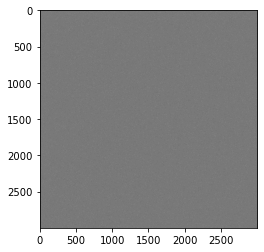

In [21]:
reco = r.get(timeout=1)

plt.imshow(reco, cmap="gray")
print("Max pixelwise diff:", np.max(reco - im))

<font color='blue'>Nachfolgend wird wieder der mit nvidia Nsight Compute generierte Report angezeigt:</font>

<img src="images/ncu_v4.png" alt="nvidia nsight compute v4"/> 

<font color='blue'>Da hier der selbe Kernel wie bei der Variante 2 verwendet wird, unterscheiden sich die Werte im Report nicht besonders. Ein Unterschied liegt darin, dass nun mehrere Reports generiert wurden, nähmlich pro Rekonstruiertem Bild einen (1).</font>


<font color='blue'>Der mit Nsight Compute generiert Report evaluiert nur den Cuda Kernel. Aktionen wie H2D oder D2H werden nicht ausgewertet. Um das komplete System zu evaluierten, ist Nvidia's Nsight Systems das korrekte Tool. Für eine Ausführliche Auswertung fehlte mir hier leider die Zeit.</font>

#### 6.2 Analyse
Vergleiche den Speedup für deine parallele Implementierung im Vergleich zur seriellen Rekonstruktion einzelner Bilder. Analysiere und diskutiere in diesem Zusammenhang die Gesetze von Amdahl und Gustafson in ca. 300 Wörtern.

<font color='blue'>Anschliessend wird nun die Rekonstruktion für mehrere Bilder evaluiert. Es wird sowohl die Rekonstruktion mit den originalen MRI Bildern mit einer Auflösung von 170x256 Pixeln, als auch eine Variante 3000x3000 Pixeln verglichen. Für die Evaluation wird 20 Mal die u, s, und vt Matrize mit maximalem k für dasselbe Bild rekonstruiert.
Neben der Variante mit dem Multiprocessing und den separaten Streams werden auch die alten Varianten mit einem seriellen For-Loop verglichen.
</font>

In [26]:
import time

def log_time(method):
    start = time.time()
    method()
    stop = time.time()
    return stop - start


methods = {
    "reconstruct_svd": lambda: [reconstruct_svd(u, s, vt, k) for (u, s, vt, k) in deco_imgs],
    "reco_svd_cuda_1": lambda: [reco_svd_cuda_1(u, s, vt, k) for (u, s, vt, k) in deco_imgs],
    "reco_svd_cuda_2": lambda: [reco_svd_cuda_2(u, s, vt, k) for (u, s, vt, k) in deco_imgs],
    "reco_svd_cuda_3": lambda: [reco_svd_cuda_3(u, s, vt, k) for (u, s, vt, k) in deco_imgs],
    "reco_svd_cuda_4.w1": lambda: v4.reconstruct_svd_cuda_mp(deco_imgs, 1),
    "reco_svd_cuda_4.w2": lambda: v4.reconstruct_svd_cuda_mp(deco_imgs, 2),
    "reco_svd_cuda_4.w4": lambda: v4.reconstruct_svd_cuda_mp(deco_imgs, 4),
    "reco_svd_cuda_4.w6": lambda: v4.reconstruct_svd_cuda_mp(deco_imgs, 6),
    "reco_svd_cuda_4.w8": lambda: v4.reconstruct_svd_cuda_mp(deco_imgs, 8)
}

run_cell = False

if run_cell:
    
    times = {}
    for m in methods.keys():
        times[m] = log_time(methods[m])

    results = pd.DataFrame({"method":times.keys(), "time [s]":times.values()})
    results["avg_time_per_image [s]"] = results["time [s]"] / len(deco_imgs)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=results["avg_time_per_image [s]"], y=results["method"])
    plt.title("Duration for reconstructing ")
    plt.show()

<font color='blue'>Die nachfolgenden Visualisierungen zeigen die durchschnittlichen Rekonstruktionszeiten pro Bild in Sekunden für verschiedene Varianten:
- reconstruct_svd: Rekonstruktion mit numpy und for-loop
- reconstruct_svd_cuda_1: Rekonstruktion mit cuda ohne Shared Memory, for-loop
- reconstruct_svd_cuda_2: Rekonstruktion mit cuda mit Shared Memory, for-loop
- reconstruct_svd_cuda_3: Rekonstruktion mit cuda mit Shared Memory mit pre-loading, for-loop
- reconstruct_svd_cuda_4.w*X*: Rekonstruktion mit Multiprocessing und Streams mit *X* Prozessen
</font>

<font color='blue'>**RTX 2070 ti 170x256 Pixel**</font>
<img src="images/RTX 2070/170x256.png" alt="170x256.png"/> 

<font color='blue'>Bei den kleinen Bildern ist die Variante mit NumPy mit ganz klar am schnellsten. Anschliessend folgen die Rekonstruktionen mit dem for-loop. Deutlich länger benötigen die Varianten mit dem Multiprocessing und den Streams. Das hat mit dem Overhead zu tun, der bei der Initialisierung der Prozesse und Streams anfällt. Je mehr Prozesse initialisiert werden, umso länger dauert die Ausführung für die Rekonstruktion der Bilder.</font>

<font color='blue'>**RTX 2070 ti 3000x3000 Pixel**</font>
<img src="images/RTX 2070/3000x3000.png" alt="170x256.png"/> 

<font color='blue'>Bei den grösseren Bildern ist die Variante mit NumPy nicht mehr ganz so schnell. Es fällt auf, dass die Variante mit dem vorladen der Threadblöcke ins Shared Memory mit abstand am bessten ist. Sie ist nun mehr als doppelt so schnell wie die variante mit shared memory ohne pre loading. Das ist etwas seltsam, ich Anhand der mit Nvidia Nsight Computing generierten Reports, die Variante ohne Shared Memory als effizienter engeschätzt habe.
Die Varianten mit dem Multiprocesssing mehrerer Bilder sind nun Proportional näher an die anderen Varianten herangekommen, sie aber immer noch etwas schlechter. 
    


<font color='blue'>**Optimierungsvorschläge:** Bei älteren Grafikkarten kann es sein, dass die Auslastung der GPU beim Multiprocessing noch nicht optimal genutzt wird. Um die Auslastung zwischen CPU- und GPU-Aufgaben auszugleichen, werden MPI-Prozessen oft einzelne CPU-Kerne in einer Multi-Core-CPU-Maschine zugewiesen, sodass eine CPU-Kern-Parallelisierung von potenziellen Bottleneckes möglich ist. Infolgedessen kann es vorkommen, dass die Arbeitsmenge, die jedem einzelnen MPI-Prozess zugewiesen wird, den Grafikprozessor nicht ausreichend auslastet, wenn der MPI-Prozess mit CUDA-Kernen beschleunigt wird. Während jeder MPI-Prozess schneller abläuft, wird die GPU ineffizient genutzt. </font>

<font color='blue'>Der Multi-Process Service nutzt die Parallelität zwischen den MPI-Prozessen und erhöht so die Gesamtauslastung des Grafikprozessors. Leider ist dieser jedoch nur auf Linux verfügbar, weshalb ich hier auf weitere Schritte in diese Richtung verzichte.</font>

In [23]:
### Colab Spefific 

# from google.colab import files
# src = list(files.upload().values())[0]
# open('v4.py','wb').write(src)

In [24]:
# # Start the multi-process service control # Start the mps as deamon
# !nvidia-cuda-mps-control -d
# !ps -ef | grep mps 

In [25]:
# !echo quit | nvidia-cuda-mps-control # Shut the daemon down.

#### 6.3 Komponentendiagramm

Erstelle das Komponentendiagramm dieser Mini-Challenge für die Rekunstruktion mehrere Bilder mit einer GPU-Implementierung. Erläutere das Komponentendigramm in 3-4 Sätzen.


<img src="images/Komponentendiagram.png" alt="Komponentendiagram"/> 

<font color='blue'>Der Host regelt die einzelnen Prozesse für die Rekonstruktion mehrerer Bilder über den Multiprocess Manager. In den einzelnen Prozessen wird zu beginn ein separater CUDA Stream initiiert. Anschliessend werden die zuerlegten u, s, und vt Matrizen aus der SVD Queue geladen und über den Stream via H2D zur GPU geladen. Nach der Rekonstruktion wird das Rekonstruierte Bild via D2H wieder zurück auf die CPU geladen und innerhalb des Prozesses in eine Rekonstruktionsqueue gespeichert. Die Rekonstruierten Bilder aus allen Streams befinden sich danach in der Reco Queue. </font>

### 7 Reflexion

Reflektiere die folgenden Themen indem du in 3-5 Sätzen begründest und anhand von Beispielen erklärst.

1: Was sind deiner Meinung nach die 3 wichtigsten Prinzipien bei der Beschleunigung von Code?

<font color='blue'>Die Verwendung von Loops in Python kann (besonders bei Verschachtelung) schnell zu einem Bottleneck im Code führen. Während sie früher in imperativen Programmiersprachen oft eingesetzt wurden, gibt es in Python ausreichend Methoden und Packages welche dieselbe Funktionalität bieten. Eine weitere Möglichkeit wäre die Vektorisierung von Anwendungen. Als Beispiel in dieser Minichallenge dient hier gleich die Matrizen-Multiplikation mit NumPy, welche deutlich optimierter läuft, als das durch eine reine Python Implementierung möglich wäre.</font>

<font color='blue'>Ist der Code von vielen OI-gebundenen Opperationen abhängig, kann der Einsatz von Multithreading sinnvoll sein. In dieser Minichallenge sehe ich jedoch keinen sinvollen Einsatz von Multithreading.</font>

<font color='blue'>Gibt es hingegen viele identische Opperationen im Code mit hoher CPU last, kann der Einsatz von Multiprocessing oder das Auslagern auf die GPU sinvoll sein.</font>

2: Welche Rechenarchitekturen der Flynnschen Taxonomie wurden in dieser Mini-Challenge wie verwendet?

<font color='blue'> Berechnungen auf der CPU funktionieren nach dem Rechenparadigma *Single Instruction, Single Data (SISD)*, da eine Instruktion nach einander auf einem einzelnen Thread ausgeführt wird.
Die GPU wurde hingegen nach dem Rechenparadigma *Single Instruction, Multiple Data (SIMD)* konzipier, da hier einzelne Instruktionen mit dem Streaming Multiprocessor auf mehreren Threads ausgeführt wird.
Bei der Verwendung von Multiprocessing auf der GPU wird hingegen *Multiple Instruction, Multiple Data (MIMD)* angewendet, da hier unterschiedliche Instruktionen auf mehreren Threads ausgeführt werden.
</font>

3: Haben wir es in dieser Mini-Challenge hauptsächlich mit CPU- oder IO-Bound Problemen zu tun? Nenne Beispiele.

<font color='blue'>In dieser Challenge gibt es primär eine CPU gebundene Belastung, was der Multiplikation der Matrizen mit einer asymptotische Komplexität von O(n^3) geschuldet ist. Wird die Berechnung nun auf die GPU verlagert, kann zusätzlich noch eine IO gebundene Limitierung hinzukommen, da die Daten vom Host zum Device geladen, auf der GPU verrechnet und anschliessend wieder zurückladen werden müssen.</font>

4: Wie könnte diese Anwendung in einem Producer-Consumer Design konzipiert werden?

<font color='blue'>Die Anwendung könnte z.B. zum komprimierten Versenden von Bildern verwendet werden. Dabei wird ein Bild mittels SVD zerlegt und auf eine bestimmte Anzahl an Singulärwerten gekürzt. Anschliessend sendet der Producer die zerlegten Matrizen. Der Consumer erhält die reduzierten Matrizen und kann das Bild mit nur minimalen Verlusten Rekonstruieren. </font>

5: Was sind die wichtigsten Grundlagen, um mehr Performance auf der GPU in dieser Mini-Challenge zu erreichen?

<font color='blue'>Der Grundgedanke hinter der Performance-Steigerung durch Auslagerung auf die GPU ist, dass durch die parallelisierte Ausführung von Instruktionen die Laufzeit mehr verkürzt werden kann, als durch das Hin-, und Zurückladen der Daten verloren geht. </font>
    
<font color='blue'>Der Speicher der GPU ist von der Struktur her auf räumliche Lokalität ausgerichtet. Auf unsere Matrizenmultiplikation bezogen geht es darum, die Daten effizient von einem globalen Memory ins jeweilige Shared Memory, zu laden und von dort aus mit dem State Multiprocessor zu verrechnen. Der State Multiprocessor funktioniert, wie zuvor beschrieben, mit dem SIMD Paradigma, wodurch einzelne Instruktionen auf mehreren Threads ausgeführt werden. 
Ein weiteres Prinzip, welches eingesetzt ist, ist das der zeitlichen Lokalität. Dabei sollten Daten, welche oft zusammen und wiederkehrend verrechnet werden, zusammen ins shared Memory geladen werden, wodurch weniger ansprechen des langsamen Globalen Memorys notwendig ist. </font>
    
<font color='blue'>Generell sollten beim Zugriff auf das Shared Memory Bank-Conflicts vermieden werden, da sonst keine optimale Parallelisierung möglich ist und der wesentliche Vorteil beim Verrechnen auf der GPU verloren geht. </font>


6: Reflektiere die Mini-Challenge in ca. 300-500 Zeichen. Was ist gut gelaufen? Wo gab es Probleme? Wo hast du mehr Zeit als geplant gebraucht? Was hast du dabei gelernt? Was hat dich überrascht? Was hättest du zusätzlich lernen wollen? Würdest du gewisse Fragestellungen anders formulieren? Wenn ja, wie?

<font color='blue'>Die Minichallenge fand ich sehr lehrreich. Ich konnte eine Vielzahl an neuen Libraries und Funktionen austesten, welche ich zuvor noch nicht kannte. Die grösste Herausforderung lag definitiv beim GPU Teil der Minichallenge, da ich das zuvor nicht nie gemacht habe und auch keine konkrete Vorstellung davon hatte. Besonders vom Code auf die konkrete Ausführung auf der GPU zu schliessen, war für mich nicht ganz intuitiv. Ich denke, dass ich hier auch noch mehr Zeit hereinstecken hätte können, um noch sattelfester zu werden.</font>

<font color='blue'>Die Struktur und Aufgabenstellung der zweiten Minichallenge empfand ich als viel konkreter, was ich als eine starke Verbesserung bewerten würde. Ich fand es sehr interessant, dass sich die gesamte Minichallenge mit nur einem Problem beschäftigt hat, welches auf verschiedene Varianten gelöst werden kann. Dadurch konnte ich viel genauer die Vor- und Nachteile der unterschiedlichen Implementationen sehen. </font>

<font color='blue'>Die Datengrundlage fand ich als zu gering für den zweiten Teil der Minichallenge. Hier wäre es für die Zukunft wohl besser, grössere Bilder zu verwenden, bei denen die Implementierung auf der GPU auch tatsächlich zu einer Verbesserung führen kann. Mit den MRI Bildern ist die Auflösung einfach zu klein.</font>

